# 1. Multilayer perception (MLP)

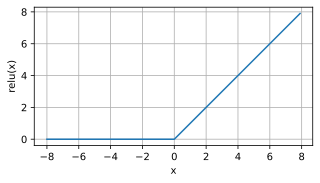

In [8]:
%matplotlib inline
import torch
from d2l import torch as d2l

# ReLU(x) (Rectified linear unit) = max(0,x) 
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

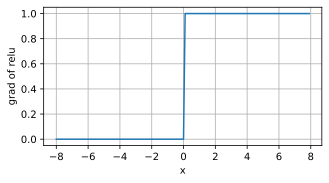

In [9]:
# graph-out ReLU function
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

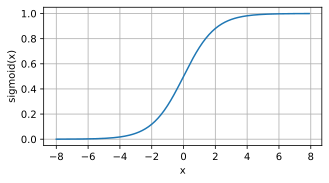

In [10]:
# sigmoid function (squashing function)
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

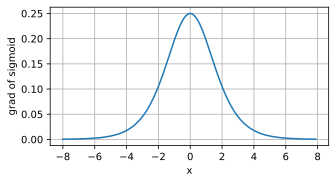

In [11]:
# derivation of sigmoid func 
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

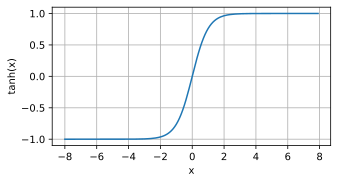

In [12]:
# tanh function
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

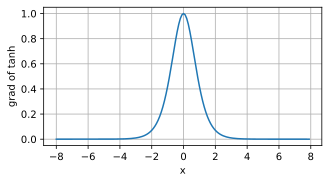

In [13]:
# derivation of tanh func 
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 2. MLP implement

In [22]:
import torch
from torch import nn
from IPython import display
from d2l import torch as d2l

In [23]:
def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self): 
        self.data = [.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def eval_accuracy(net, data_iter):
    """计算在指定数据集上的模型精度"""
    if isinstance(net, torch.nn.Module): 
        net.eval() 
    metric = Accumulator(2)  
    with torch.no_grad(): 
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) 
    return metric[0] / metric[1]


class Animator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None: legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1: self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"): y = [y]
        n = len(y)
        if not hasattr(x, "__len__"): x = [x] * n
        if self.X is None: self.X = [[] for _ in range(n)]
        if self.Y is None: self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x_arr, y_arr, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x_arr, y_arr, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [31]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_SM(net, train_iter, loss, updater)
        test_acc = eval_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    #  train_metrics have 2 returns: return metric[0] / metric[2], metric[1]/metric[2]
    # train_loss get the first ret, which is the train_loss; train_acc get the second
    train_loss, train_acc = train_metrics

In [25]:
# 加载数据 (必须在调用 eval_accuracy 之前)
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 初始化参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

# 定义激活函数和模型
def relu(X):
    return torch.max(X, torch.zeros_like(X))

def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # 隐藏层
    return (H @ W2 + b2)   # 输出层 (注意：CrossEntropyLoss内部会做softmax，这里返回raw scores)


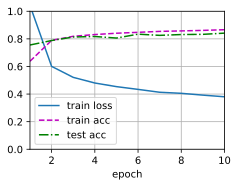

In [26]:
loss = nn.CrossEntropyLoss(reduction='none') 
num_epochs, lr = 10, 0.1
opt = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, opt)

# 3. MLP implement (lite)

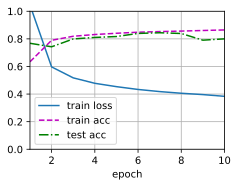

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 4. Balance ability: model selection, under/overfitting

In [28]:
# Polynomial regression
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20  # max degree of polynomial
n_train, n_test = 100, 100  # training. test dataset size
true_w = np.zeros(max_degree) # allocate as more space as possible

true_w[0:4] = np.array([5, 1.2,-3.4, 5.6]) # assign non-zero weights(coefficients) to first 4-terms
features = np.random.normal(size=(n_train + n_test, 1)) # generate random num for x in each term
np.random.shuffle(features)

# construct polynomial features: x^0, x^1, x^2,...
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    # prevent the number overflow
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!

# labels dimensions:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # add random noises

# convert numpy ndarray to tensor 
# true_w = torch.tensor(true_w, dtype=torch.float32)
# features = torch.tensor(features, dtype=torch.float32)
# poly_features = torch.tensor(poly_features, dtype=torch.float32)
# labels = torch.tensor(labels, dtype=torch.float32)
true_w, features, poly_features, labels = [torch.tensor(x, dtype= torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.0498],
         [-0.2112]]),
 tensor([[ 1.0000e+00, -1.0498e+00,  5.5106e-01, -1.9284e-01,  5.0611e-02,
          -1.0626e-02,  1.8593e-03, -2.7885e-04,  3.6593e-05, -4.2684e-06,
           4.4811e-07, -4.2766e-08,  3.7414e-09, -3.0214e-10,  2.2656e-11,
          -1.5857e-12,  1.0404e-13, -6.4250e-15,  3.7473e-16, -2.0705e-17],
         [ 1.0000e+00, -2.1120e-01,  2.2304e-02, -1.5702e-03,  8.2908e-05,
          -3.5021e-06,  1.2328e-07, -3.7195e-09,  9.8197e-11, -2.3044e-12,
           4.8670e-14, -9.3448e-16,  1.6447e-17, -2.6721e-19,  4.0311e-21,
          -5.6759e-23,  7.4923e-25, -9.3083e-27,  1.0922e-28, -1.2141e-30]]),
 tensor([0.6903, 4.7290]))

In [37]:
# train
def evaluate_loss(net, data_iter, loss): 
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    
    # no need to set bias(noises), because we have done it at the previous cell
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        train_epoch_SM(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.014655   1.2523426 -3.4227257  5.4890466]]


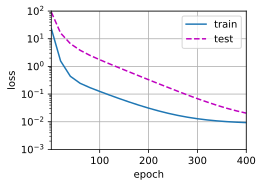

In [38]:
# Normal fitting 
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[3.3277972 3.638102 ]]


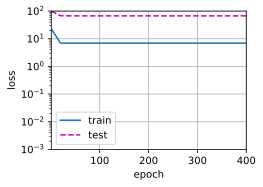

In [39]:
# Under fitting
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.995124    1.2356017  -3.3001006   5.3258677  -0.2924317   1.0501395
  -0.20585488  0.2641823  -0.19276704  0.06589586  0.10225805 -0.0217407
   0.10388265  0.08518025  0.03098097  0.09156465 -0.13471234 -0.15717746
  -0.146325   -0.18733738]]


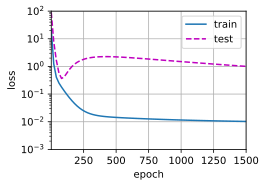

In [40]:
# Under fitting
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

# 5. Solution： weight decay implement

w的L2范数是： 12.859444618225098


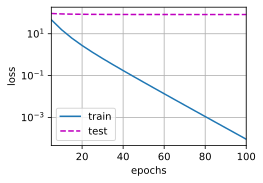

In [41]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# using 200 features to fit only 20 training samples
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# define penalty function: 0.5*||w||^2
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())
    
train(lambd=0) # serious overfitting

w的L2范数是： 0.4008139371871948


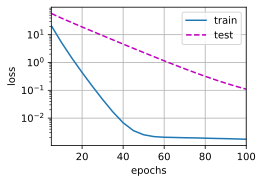

In [42]:
train(lambd = 3)

#### 5.1 Weight decay implement(lite)

w的L2范数： 14.00249195098877


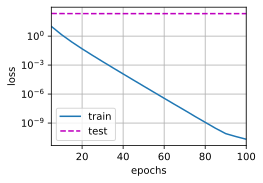

In [43]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
        
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())
train_concise(0)

w的L2范数： 0.4892179071903229


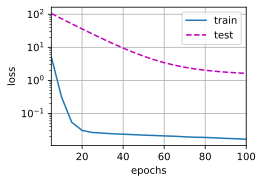

In [44]:
train_concise(3)

# 6. Better regularization：Dropout

In [45]:
# Inserting noise into each layer and activating only a portion of the neurons to regularize the model
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 # make sure the probability of dropout ∈  [0,1]
    
    if dropout == 1: # turn off every neurons
        return torch.zeros_like(X)
    if dropout == 0: # turn off dropout
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0- dropout)

X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.)) # keep every neurons
print(dropout_layer(X, 0.5)) # dropout 50% of neurons: force model to learn robust features
print(dropout_layer(X, 1.)) 


num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
        is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # only use dropout while training model
        if self.training == True:
            # adding a 'dropout layer' after a fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # repeat again
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  0., 10.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


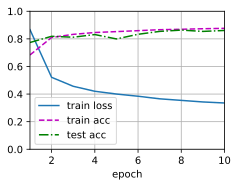

In [46]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

#### dropout implement (lite)

In [ ]:
net = nn.Sequential(nn.Flatten(), 
                    nn.Linear(784, 256),  nn.ReLU(),
                    # add a dropout layer after a fully-connected layer
                    nn.Dropout(dropout1), 
                    nn.Linear(256, 256), nn.ReLU(),
                    nn.Dropout(dropout2), 
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

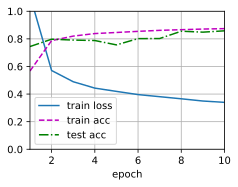

In [49]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 7. Propagation

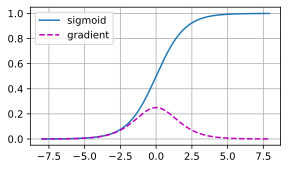

In [52]:
# 前向传播从输入到输出层顺序地计算结果并存下来，
# 反向传播则是利用链式法则的原理从输出层到输入层计算每一层数值的梯度，
# 然后再喂给优化器，优化器随后更新所有可学习的参数（权重W ， 偏置b）


# 梯度消失则是优化器对于参数的更新过小，导致模型学不动 (sol: use ReLU,...) 
%matplotlib inline
import torch
from d2l import torch as d2l
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()], legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [53]:
# 梯度爆炸的意思是优化器对参数的更新过大导致整个模型没办法稳定收敛；（sol: use a smaller lr,...）
M = torch.normal(0, 1, size=(4,4))
print('one matrix \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))
print('after multiplying 100 matrices\n', M)

one matrix 
 tensor([[ 1.7500, -0.2011, -1.0711, -0.1503],
        [-1.4296, -0.4749,  0.3870, -0.2310],
        [ 0.7513, -0.8029,  1.1245, -1.4806],
        [ 0.4592,  0.7993, -0.3967,  0.2360]])
after multiplying 100 matrices
 tensor([[ 4.9489e+23,  1.3930e+23, -1.4505e+25, -2.6354e+25],
        [-2.3711e+23, -6.6743e+22,  6.9496e+24,  1.2627e+25],
        [-2.1666e+23, -6.0986e+22,  6.3501e+24,  1.1537e+25],
        [ 1.3053e+23,  3.6743e+22, -3.8259e+24, -6.9512e+24]])
